# **Neural Networks & Deep Learning**

> 欢迎同学们观看哔哩哔哩[《数之道》相关视频](https://www.bilibili.com/video/BV12b4y1X7Wv/?spm_id_from=333.788&vd_source=2dbf3ce169def83a8e8b53329f7d2135),提升自己对神经网络的理解。

在这个作业中，我们的任务是构建一个神经网络来识别手写数字图片，本质上是一个类别数为10的图像分类问题。首先我们会搭建一个简单的**神经网络**，然后分别实现**AdaGrad、RMSprop、Momentum、Nesterov Momentum和Adam**优化器来加速模型收敛。 
需要修改代码主要在第三部分：
- 搭建三层MLP网络模型
- **实现各种优化器**
- 训练模型


## 1 导入所需的Python库

In [370]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from utils import load_mnist

from collections import OrderedDict

## 2 加载数据并可视化

在这个实验中用到的数据集是MNIST。MNIST数据集是一个手写体数据集，包含训练集**60000**张图片和测试集**10000**张图片，其中每张图片是一张**28×28**的灰度图片，图片内容为一个**0-9**表示的手写数字。
一张灰度图片读取后是二维张量的，但是我们使用的神经网络中的全连接层的输入是一维张量。所以我们需要将一张二维灰度图片转换成一个一维张量（即向量），如图1：

<div align=center> 
<img src="./images/2d_to_1d.jpg" width="300" height="300" alt="2d_to_1d" >
<br>
图1. 展开二维图片成向量
</div>

在此之后每一个样本都是一个长度为**784**（28*28）的向量。 

手写数字识别任务是一个多分类任务，共包含有10类，分别用0-9表示，为了用一个向量表示一个类别，通常使用**one-hot**编码，比如在手写数字识别中，类别0和1对应的one-hot向量分别为： 
$$\mathrm{one-hot}(0)=\begin{bmatrix}1 \\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ \end{bmatrix},\mathrm{one-hot}(1)=\begin{bmatrix}0 \\ 1\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ \end{bmatrix}$$ 

<div align=center>
</div>




### 2.1 加载数据
在训练集中，我们需要把样本的标记$Y$转化为one-hot向量。

In [371]:
#加载训练集或测试集
path = './MNIST Data' #数据集文件所在目录
# 加载训练集合测试集
# 设置normalization为True，将数据缩放到[0,1]之间
# 设置one_hot_label为True，将标签转化为one_hot向量
(x_train, y_train), (x_test, y_test) = load_mnist(path, normalize=True, one_hot_label=True)

In [372]:
print('The shape of X_train is:',x_train.shape)
print('The shape of Y_train is:',y_train.shape)
print('The shape of X_test is:',x_test.shape)
print('The shape of Y_test is:',y_test.shape)

The shape of X_train is: (60000, 784)
The shape of Y_train is: (60000, 10)
The shape of X_test is: (10000, 784)
The shape of Y_test is: (10000, 10)


### 2.2 可视化数据集
下面在训练集中选取几个图片看一下。

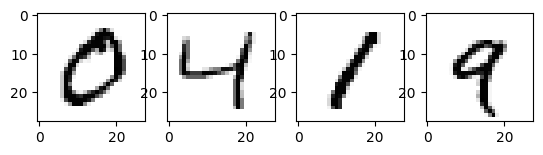

one hot 标签： [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
对应的实际标签： 0 4 1 9


In [373]:
fig = plt.figure()

ax1 = fig.add_subplot(141)
ax1.imshow(x_train[1,:].reshape(28, 28), cmap='Greys')
ax2 = fig.add_subplot(142)
ax2.imshow(x_train[2,:].reshape(28,28), cmap='Greys')
ax3 = fig.add_subplot(143)
ax3.imshow(x_train[3,:].reshape(28,28), cmap='Greys')
ax4 = fig.add_subplot(144)
ax4.imshow(x_train[4,:].reshape(28,28), cmap='Greys')
plt.show()
print('one hot 标签：',y_train[1,:],y_train[2,:],y_train[3,:],y_train[4,:])
print('对应的实际标签：',np.argmax(y_train[1,:]),np.argmax(y_train[2,:]),np.argmax(y_train[3,:]),np.argmax(y_train[4,:]))

## 3 全连接神经网络

接下来，搭建一个**三层全连接神经网络**。网络结构见图二：

<div align=center> 
<img src="./images/network_architecture.jpg" width="500" height="250" alt="network_architecture" align=center>
<br>
图2：三层全连接神经网络结构
</div>

对公式所用符号的说明：  
一般计算神经网络层数不算输入层，所以图2中为3层神经网络。用右上角的方括号表示相应的层，所有第1层的权重$W$为$W^{[1]}$，第1层的偏置项$b$为$b^{[1]}$(图中未标出)，第1层的激活值$A$为$A^{[1]}$。  

前两层的激活函数使用LeakyRelu，最后一层使用Softmax进行分类。

### 3.1 初始化网络参数

我们规定第1层的神经元个数为300，第二层个数为300，最后一层为10。输入向量$X$的维度为784，那么整个网络对应的参数也就可以确定了。  
$W^{[1]}$的shape为$(784,300)$，$b^{[1]}$的shape为$(300,)$  
$W^{[2]}$的shape为$(300,300)$，$b^{[2]}$的shape为$(300,)$  
$W^{[3]}$的shape为$(300,10)$，$b^{[3]}$的shape为$(10,)$  
这里**使用随机正态分布乘上比例因子0.01来初始化$W$， 把$b$都初始化为0**.  
**Hint**: 使用`np.random.randn()`,`np.zeros()`  


In [374]:
def initialize_parameters(input_size, hidden_size, output_size, weight_init_std):
    """
    @param input_size:输入向量维度
    @param hidden_size:中间神经元个数
    @param output_size:输出层神经元个数
    @param weight_init_sta:比例因子
    """
    np.random.seed(1)
    params = {}

    params['W1'] = np.random.randn(input_size,hidden_size) * weight_init_std
    params['b1'] = np.zeros((hidden_size,)) #请参考样例完成代码
    ### START CODE HERE ### 
    params['W2'] = np.random.randn(hidden_size,hidden_size) * weight_init_std
    params['b2'] = np.zeros((hidden_size,))
    params['W3'] = np.random.randn(hidden_size,output_size) * weight_init_std
    params['b3'] = np.zeros((output_size,))
    
    ### END CODE HERE ### 

    print("W1's shape:",params['W1'].shape)
    print("b1's shape:",params['b1'].shape)
    print("W2's shape:",params['W2'].shape)
    print("b2's shape:",params['b2'].shape)
    print("W3's shape:",params['W3'].shape)
    print("b3's shape:",params['b3'].shape) #请在调用该函数的地方观察该神经网络各个参数的shape，是否符合预期
    
    return params

### 3.2 定义神经网络的每一层
我们将用单独的类来实现各种神经网络层：
- LeakyRelu
- Affine
- Softmax-with-loss

#### 3.2.1 LeakyRelu层

激活函数LeakyRelu的表达式为：
$$
\left\{\begin{matrix}
x & (x>0)\\ 
\alpha x & (x \leq 0)
\end{matrix}\right.
$$
可以通过上式求出$y$关于$x$的导数：
$$
\frac{\partial y}{\partial x} = \left\{\begin{matrix}
1 & (x>0)\\ 
\alpha & (x \leq 0)
\end{matrix}\right.
$$

如果正向传播时的输入$x$大于0，则反向传播会将下游的值原封不动地传给上游。反过来，如果正向传播时的$x$小于等于0，则反向传播中传给上游的信号将乘上一个很小的常数，保证neuron依然起作用。

<div align=center>
<img src="./images/LeakyReLu.png" width="350" height="250" alt="ReLU" align=center>
<br>
图3. LeakyRelu
</div>

In [375]:
class LeakyRelu:
    def __init__(self):
        self.mask = None 
        self.alpha = 0.1
        
    def forward(self, x):
        self.mask = (x <= 0) #mask表示选择出x的值中小于等于0的部分内容
        out = x.copy()
        ### START CODE HERE ###  #请参考LeakyRelu表达式实现前向传播过程
        out[self.mask] = self.alpha * x[self.mask]
        ### END CODE HERE ### 
        return out

    def backward(self, dout):
        ### START CODE HERE ###  #请参考LeakyRelu表达式y关于x的导数公式实现反向传播过程
        dout[self.mask] = self.alpha * dout[self.mask]
        ### END CODE HERE ### 
        dx = dout
        return dx

测试效果

In [376]:
leakyRelu = LeakyRelu()
x = np.array( [[1.0, -0.5], [-2.0, 3.0]] )
leakyRelu.forward(x), leakyRelu.backward(x)

(array([[ 1.  , -0.05],
        [-0.2 ,  3.  ]]),
 array([[ 1.  , -0.05],
        [-0.2 ,  3.  ]]))

#### 3.2.2 Affine层

神经网络的正向传播中，为了计算加权信号的总和，使用了矩阵的乘积运算，回顾一下公式：
$$
Y = XW + B
$$
即`Y = np.dot(X, W) + B`。假设X，W，B的shape分别为(2,)、(2,3)、(3,)如图4，现在将这里进行的求矩阵的乘积与偏置的和的运算用计算图表示出来。将乘积运算用“dot”节点表示的话，则np.dot(X, W) + B的运算如图5：
<div align=center>
<img src="./images/Affine1.png"><br>
图4. 单向量正向传播
</div>
<div align=center>
<img src="./images/Affine2.png"><br>
图5. Affine
</div>

以矩阵为对象的反向传播，按矩阵的各个元素进行计算时，步骤和以标量为对象的计算图相同。用公式表示：
$$
\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot W^T
$$
  
$$
\frac{\partial L}{\partial W} = X^T \cdot \frac{\partial L}{\partial Y}
$$
根据这个式子我们可以得到一个向量反向传播的计算图（见图6）。
<div align=center>
<img src="./images/Affine3.png"><br>
图6. 单向量反向传播
</div>


现在我们考虑N个数据一起进行正向传播（见图7），与刚刚不同的是，现在输入X的shape是(N, 2)。之后就和前面一样，在计算图上进行矩阵计算。反向传播时，需要注意矩阵的shape，推导出$\frac{\partial L}{\partial X}$ 和 $\frac{\partial L}{\partial W}$的过程与单个向量类似。

<div align=center>
<img src="./images/Affine4.png"><br>
图7. N个向量反向传播
</div>



In [377]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 权重和偏置参数的导数
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        ### START CODE HERE ### 
        out = np.dot(x, self.W) + self.b
        ### END CODE HERE ### 
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        ### START CODE HERE ### 
        self.dW = np.dot(self.x.T, dout)
        self.db = dout[0]
        ### END CODE HERE ###      
        dx = dx.reshape(*self.original_x_shape)  # 还原输入数据的形状（对应张量）
        return dx

测试效果

In [378]:
w = np.ones([2, 3])
b = np.ones(3)
affine = Affine(w, b)
x = np.ones([1, 2])
# 假设 l = sum(y)
l = np.sum(affine.forward(x))
dout = np.ones([1,3])
l, affine.backward(dout)


(9.0, array([[3., 3.]]))

#### 3.2.3 Softmax-with-Loss层

softmax函数会将输入值正规化后输出，如图所示：
<div align=center>
<img src="./images/softmax.png">
<br>
图8. Softmax层
</div>

用$x_i$表示向量$x$的第$i$个分量。具体公式为
$$softmax(x_i)=\frac{e^{x_i}}{\sum_{j=1}^{C}{e^{x_j}}}$$ 


当最后一层为softmax时，使用的损失函数一般为交叉熵函数（$C$是类别的数量，在本次实验中即为10）：  
$$L(\hat{y},y)=-\sum_{j=1}^{C}{y_jlog\hat{y_j}}$$  
成本函数为（$m$是mini-batch的大小）：  
$$J(W^{[1]},b^{[1]},...)=\frac{1}{m}\sum_{i=1}^{m}{L(\hat{y}^{(i)},y^{(i)})}$$  
**mini-batch**：训练集共有60000个图片，我们不能把$(60000,784)$的张量直接放入神经网络计算。因此，每次正向传播从中选取m个图像来进行前向传播，所以输入的张量大小为$(m,784)$.

**Hint**：最后的Loss是个标量 

In [379]:
def softmax(x):
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T 

def cross_entropy_error(pred, y):
    if pred.ndim == 1:
        y = y.reshape(1, y.size)
        pred = pred.reshape(1, pred.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if y.size == pred.size:
        y = y.argmax(axis=1)
             
    batch_size = pred.shape[0]
    
    res = None

    res = -np.sum(np.log(pred[:, y] + 1e-7)) / batch_size
    
    return res

实现Softmax 层（已完成）

考虑到这里也包含作为损失函数的交叉熵误差（cross entropy error），所以称为“Softmax-with-Loss 层”。Softmax-with-Loss 层（Softmax函数和交叉熵误差）的计算图如图9所示。

<div align=center>
<img src="./images/softmax-cross.png" align=center>
<br>
图9. Softmax-with-Loss 层
</div>
可以看到，Softmax-with-Loss 层有些复杂。这里只给出了最终结果。

In [380]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.pred = None # softmax的输出
        self.y = None # 监督数据

    def forward(self, x, y):
        self.y = y
        self.pred = softmax(x)
        self.loss = cross_entropy_error(self.pred, self.y)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.y.shape[0]
        if self.y.size == self.pred.size: # 监督数据是one-hot-vector的情况
            dx = (self.pred - self.y) / batch_size
        else:
            dx = self.pred.copy()
            dx[np.arange(batch_size), self.y] -= 1
            dx = dx / batch_size
        
        return dx

### 3.3 搭积木
现在我们把之前的每一层组合在一起就能搭成我们自己的三层神经网络了。
神经网络学习的步骤大致有5步：
1. 初始化权重
2. 随机选择一部分数据
3. 计算梯度
4. 更新参数
5. 重复步骤2,3,4


In [381]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        
        # 初始化权重
        self.params = initialize_parameters(input_size, hidden_size, output_size, weight_init_std)
        # 记录训练次数 adam里要用
        self.t = 0

        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['LeakyRelu1'] = LeakyRelu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['LeakyRelu2'] = LeakyRelu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
    
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        # 前向传播
        pred = x.copy()
        for layer in self.layers.values():
            # 通过forward函数完成前向传播
            ### START CODE HERE ###
            pred = layer.forward(pred) #对每一层进行前向传播预测结果
            ### END CODE HERE ###
            
        return pred
        
    def loss(self, x, y):
        # 计算交叉熵损失
        ### START CODE HERE ### 
        pred = self.predict(x)  #计算关于x的预测结果
        loss =  self.lastLayer.forward(pred, y)#使用SoftmaxWithLoss层计算预测结果和y之间的交叉熵损失
        ### END CODE HERE ### 
        return loss
    
    def accuracy(self, x, y):
        # 输入数据x和标签y，输出当前神经网络的预测准确率
        accuracy = None
        pred = self.predict(x)
        pred = np.argmax(pred, axis=1)
        if y.ndim != 1:
            y = np.argmax(y, axis=1)
        
        accuracy = np.sum(pred == y) / float(x.shape[0])

        return accuracy
        
    def gradient(self, x, y):
        # 前向传播
        self.loss(x, y)

        # 反向传播
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        
        return grads

### 3.4 进行训练

#### 3.4.1 定义参数更新函数

In [382]:
def update_parameters(network, grads, learning_rate=0.001):
    """
    使用梯度下降法更新network的参数
    """

    #在这里我们给出了最基础的梯度下降法更新网络参数的实现代码，请同学们参考并完成其他优化算法的代码
    
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grads[key]  #在network现在的参数基础上减去学习率*梯度
    
    return 

#### 3.4.2 定义训练函数

In [383]:
def train_network(network, update_params_method, iters_num, train_size, batch_size, learning_rate):
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)

    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = y_train[batch_mask]
        network.t += 1

        # 计算梯度
        grad = network.gradient(x_batch, t_batch)

        # 更新梯度
        update_params_method(network, grad, learning_rate)

        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, y_train)
            test_acc = network.accuracy(x_test, y_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print("Train acc:{:<.6f}\tTest acc:{:<.6f}".format(train_acc, test_acc))

In [384]:
# 读入数据
(x_train, y_train), (x_test, y_test) = load_mnist(path, normalize=True, one_hot_label=True)

In [385]:
# 定义神经网络
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [386]:
iters_num = 10000 #迭代次数
train_size = x_train.shape[0] #训练集的样本数量
batch_size = 100 #batch大小
learning_rate = 0.1 #学习率
#train_network(network, update_parameters, iters_num, train_size, batch_size, learning_rate) #开始训练网络

### 3.5 梯度下降优化算法
下面回顾几种上课讲过的优化算法，注意它们之间的差异与联系。

#### 3.5.1AdaGrad  

当$J(\theta)$收敛到最低值附近时，因为步长$\alpha$大小固定的原因，$J(\theta)$会在最低值附近徘徊，而不能到达最低值。因此，AdaGrad的想法是随着迭代次数的增加降低学习率$\alpha$，学习率$\alpha$衰减的方式是
$$
\alpha^t = \frac{\alpha}{\sqrt{t+1}}
$$
其中t表示第t次迭代。

如果梯度数值小，$J(\theta)$的移动步长小，$J(\theta)$在坡度平缓的区域内下降速度会变慢。AdaGrad使用均方根来加快$J(\theta)$在平缓区域的下降速度。均方根的表示为
$$
\sigma^t = \sqrt{\frac{1}{t+1} \sum_{i=0}^{t}(g^i)2}
$$
其中$g^i$表示历史的梯度值。AdaGrad 的更新参数公式是
$$
\begin{aligned}
\theta^{t+1} & := \theta^t - \frac{\alpha^t}{\sigma^t} g^t \\
& := \theta^t - \frac{\alpha}{\sqrt{\sum_{i=0}^t (g^i)^2}} g^t
\end{aligned}
$$
在坡度平缓的区域，均方根的数值小，梯度除以一个数值小的数会变大，从而加大了$J(\theta)$移动步长，也因此加快梯度下降速度。但是，AdaGrad的缺点是，随着迭代次数的增大，均方根会越来越大，梯度趋近于0，导致训练提前停止。为了防止分母为0，我们给分母加上一个小数值$\epsilon =10^{-7}$。
$$
\theta^{t+1} := \theta^t - \frac{\alpha}{\sqrt{\sum_{i=0}^t (g^i)^2} + \epsilon} g^t
$$

我们可以看到分母里会计算所有历史梯度值的平方和，所以在实现的时候不用保存所有的历史梯度值，只需要保存一个纪录所有历史梯度平方和的值即可。每个参数的历史梯度和初始值为0。   
在代码实现中，我们使用`epsilon`代表ε  

In [387]:
def initialize_grads_squared(network):
    """
    初始化历史梯度和
    """
    grads_squared = {}
    
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        
        grads_squared[key] = np.zeros(network.params[key].shape)
        
    return grads_squared

In [388]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
grads_squared = initialize_grads_squared(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [389]:
import numpy as np
def update_parameters_with_adagrad(network, grads, learning_rate=0.001, epsilon = 1e-7):
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
        
        #计算历史梯度平方和
        grads_squared[key] += np.square(grads[key])
        network.params[key] -= learning_rate/(np.sqrt(grads_squared[key]) + epsilon) * grads[key]
        ### END CODE HERE ###
        
    return 

In [390]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_adagrad, iters_num, train_size, batch_size, learning_rate)

Train acc:0.307817	Test acc:0.309800


Train acc:0.868700	Test acc:0.871100
Train acc:0.885800	Test acc:0.888400
Train acc:0.894000	Test acc:0.895600
Train acc:0.898600	Test acc:0.899300
Train acc:0.902033	Test acc:0.902400
Train acc:0.905283	Test acc:0.904700
Train acc:0.907867	Test acc:0.907500
Train acc:0.908817	Test acc:0.909300
Train acc:0.912067	Test acc:0.910100


KeyboardInterrupt: 

#### 3.5.2 RMSprop  
从AdaGrad算法的公式可看出，所有时刻的梯度都对当前的参数更新有影响。如果早先的梯度并不是一个正确的方向，那么这些糟糕的梯度还是会影响到当前的参数更新。因此，RMSprop相当于就是只记录当前时刻前的某一段历史梯度和而不是所有历史梯度和。  
RMSprop算法的公式如下：  
$$
 u^0 = 0 \\
 u^{t+1} = \rho u^t + (1-\rho) [\nabla J(\theta ^t)]^2 \\ 
 \theta^{t+1} = \theta^t - \frac{\alpha}{\sqrt{u^{t+1}}+\epsilon}\nabla J(\theta ^t) 
$$
这里$\rho$是超参数，一般设为0.999，也不会调它。$\epsilon$是防止分母为0。另外值得注意的是，因为要整合这几个算法在一起，而Adam算法又融合了各种算法，所以，关于优化算法的超参数的命名与Adam里保持一致，公式里的$\rho$用下面参数`beta`代替。这些算法几乎都要保存一些变量，它们的初始化基本与AdaGrad初始化的方法一致，所以这部分初始化的代码就不重复了。  

In [ ]:
def update_parameters_with_rmsprop(network, grads, learning_rate=0.001, epsilon = 1e-7, beta=0.999):
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
        
        #公式里的u就是这里的 grads_squared         
        grads_squared[key] = beta * grads_squared[key] + (1 - beta) * grads[key] ** 2
        network.params[key] -= learning_rate / (np.sqrt(grads_squared[key]) + epsilon) * grads_squared[key]
        
        ### END CODE HERE ###
    return 

In [ ]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
grads_squared = initialize_grads_squared(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [ ]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_rmsprop, iters_num, train_size, batch_size, learning_rate)

Train acc:0.154500	Test acc:0.145600
Train acc:0.964933	Test acc:0.959300
Train acc:0.975267	Test acc:0.968700
Train acc:0.984133	Test acc:0.973400
Train acc:0.987083	Test acc:0.975700
Train acc:0.988967	Test acc:0.975400
Train acc:0.992717	Test acc:0.977400
Train acc:0.994050	Test acc:0.977900
Train acc:0.993700	Test acc:0.978300
Train acc:0.993617	Test acc:0.976400
Train acc:0.993650	Test acc:0.976300
Train acc:0.993333	Test acc:0.976200
Train acc:0.995350	Test acc:0.980400
Train acc:0.996850	Test acc:0.979400
Train acc:0.996483	Test acc:0.977900
Train acc:0.995717	Test acc:0.979400
Train acc:0.996217	Test acc:0.978300


#### 3.5.3 Momentum
动量梯度下降（Gradient Descent with Momentum）基本思想就是计算梯度的指数加权平均数，并利用该指数加权平均数更新权重。具体过程为：
$$
v^0 = 0 \\
v^{t+1}  = \rho v^t +\alpha \nabla J(\theta ^t) \\
\theta^{t+1} = \theta ^t - v^{t+1}
$$

这里的$\rho$一般取0.9。 

In [ ]:
def initialize_velocity(network):
    v = {}
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        v[key] = np.zeros((network.params[key]).shape) 
    return v

In [ ]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
v = initialize_velocity(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [ ]:
def update_parameters_with_momentum(network, grads, learning_rate=0.001, beta=0.9):
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
        
        #公式里的u就是这里的 grads_squared         
        v[key] = beta * v[key] + learning_rate * grads[key]
        network.params[key] -= v[key]
        
        ### END CODE HERE ###
    return 

In [ ]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_momentum, iters_num, train_size, batch_size, learning_rate)

Train acc:0.085050	Test acc:0.084000
Train acc:0.112367	Test acc:0.113500
Train acc:0.282417	Test acc:0.284400
Train acc:0.437133	Test acc:0.447100
Train acc:0.702383	Test acc:0.715900
Train acc:0.789133	Test acc:0.797000
Train acc:0.828717	Test acc:0.835100
Train acc:0.852583	Test acc:0.856400
Train acc:0.869817	Test acc:0.873100
Train acc:0.882033	Test acc:0.884900
Train acc:0.890717	Test acc:0.890700
Train acc:0.896317	Test acc:0.894500
Train acc:0.899783	Test acc:0.899300
Train acc:0.904583	Test acc:0.902500
Train acc:0.908617	Test acc:0.906200
Train acc:0.911867	Test acc:0.909400
Train acc:0.914083	Test acc:0.912900


#### 3.5.4 Nesterov Momentum  
Nesterov Momentum算法与Momentum不同的是在于，它会提前计算一个在速度作用后的梯度。具体算法如下：
$$
v^{t+1} = \rho v^t + \alpha \nabla J(\theta ^t - \rho v^t) \\
\theta^{t+1} = \theta ^t - v^{t+1}
$$
但是在实现的时候，我们是不会算一次$J(\theta ^t)$再算一次$\nabla J(\theta ^t - \rho v^t)$的。具体编程实现时上式等价于下式：
$$
 v^{t+1} = \rho v^t + \alpha \nabla J(\theta ^t) \\
 \theta^{t+1} = \theta ^t - \rho v^{t+1} - \alpha \nabla J(\theta ^t)
$$
这里的$\rho$一般取0.9。  

In [ ]:
def update_parameters_with_nesterov_momentum(network, grads, learning_rate=0.001, beta=0.9):
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
                
        v[key] = beta * v[key] + learning_rate* grads[key]
        network.params[key] -= beta * v[key] + learning_rate * grads[key]
        
        ### END CODE HERE ###
    return 

In [ ]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
v = initialize_velocity(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [ ]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_nesterov_momentum, iters_num, train_size, batch_size, learning_rate)

Train acc:0.084783	Test acc:0.084100
Train acc:0.112367	Test acc:0.113500
Train acc:0.283333	Test acc:0.285600
Train acc:0.440450	Test acc:0.450000
Train acc:0.703683	Test acc:0.717300
Train acc:0.789483	Test acc:0.796600
Train acc:0.829000	Test acc:0.835400
Train acc:0.853417	Test acc:0.856900
Train acc:0.869817	Test acc:0.873300
Train acc:0.882167	Test acc:0.884300
Train acc:0.890650	Test acc:0.890700
Train acc:0.896400	Test acc:0.894400
Train acc:0.899950	Test acc:0.899100
Train acc:0.904733	Test acc:0.902300
Train acc:0.908700	Test acc:0.906000
Train acc:0.911867	Test acc:0.909300
Train acc:0.914117	Test acc:0.912800


#### 3.5.5 Adam
Adam优化算法（Adaptive Moment Estimation）是将Momentum和RMSprop结合在一起的算法，具体过程如下
$$
u^0 = 0 \\
v^0 = 0 \\
u^{t+1}  = \rho_2 u^t +(1-\rho_2) [\nabla J(\theta ^t)]^2 \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{u^{t+1}}+\epsilon}v^{t+1}
$$
从上式可以看到，在最开始更新时，$u^{t},v^{t}$都是很小的。所以需要对早期的更新进行一个bias correction。完整公式如下
$$
u^0 = 0 \\
v^0 = 0 \\
u^{t+1}  = \rho_2 u^t +(1-\rho_2) [\nabla J(\theta ^t)]^2 \\
u^{t+1}_{corrected} = \frac{u^{t+1}}{1-\rho_2^t} \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
v^{t+1}_{corrected} = \frac{v^{t+1}}{1-\rho_1^t} \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{u^{t+1}_{corrected}}+\epsilon}v^{t+1}_{corrected}
$$

其中，一般设$\rho_1=0.9,\rho_2=0.999$.$\epsilon$也是防止分母过小或等于0.  

In [ ]:
def initialize_adam(network) :
    v = {}
    u = {}

    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        v[key] = np.zeros(np.shape(network.params[key]))
        u[key] = np.zeros(np.shape(network.params[key]))
            
    return v, u

In [ ]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
v, u = initialize_adam(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [ ]:
def update_parameters_with_adam(network, grads, learning_rate=0.001, epsilon=1e-7, beta1=0.9, beta2=0.999):
    v_corrected = {}
    u_corrected = {} 
    t = network.t #当前迭代次数
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
                
        v[key] = beta1 * v[key] + (1 - beta1) * grads[key]
        v_corrected[key] = v[key] / (1 - beta1)
        
        u[key] = beta2 * u[key] + (1 - beta2) * np.square(grads[key])
        u_corrected[key] = u[key] / (1 - beta2)
        
        network.params[key] -= learning_rate / (np.sqrt(u[key]) + epsilon) * v[key]
        
        ### END CODE HERE ###
    return 

In [ ]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_adam, iters_num, train_size, batch_size, learning_rate)

Train acc:0.224533	Test acc:0.221600
Train acc:0.951333	Test acc:0.949100
Train acc:0.966433	Test acc:0.962300
Train acc:0.973433	Test acc:0.965400
Train acc:0.979767	Test acc:0.971100
Train acc:0.984167	Test acc:0.973100
Train acc:0.985467	Test acc:0.973900
Train acc:0.989733	Test acc:0.976600
Train acc:0.990800	Test acc:0.977000
Train acc:0.991833	Test acc:0.977500
Train acc:0.994117	Test acc:0.979000
Train acc:0.994617	Test acc:0.977800
Train acc:0.994800	Test acc:0.977800
Train acc:0.997283	Test acc:0.978100
Train acc:0.997100	Test acc:0.977700
Train acc:0.995500	Test acc:0.978100
Train acc:0.997633	Test acc:0.980000


#### 3.5.6 AdaBelief
Adam优化算法中，梯度更新的方向是 $\frac{v_{t+1}}{\sqrt{u_{t+1}}}$, 其中 $u_{t+1}$ 是 $[\nabla J(\theta ^t)]^2$ 的指数移动平均(exponential moving average,EMA)。

AdaBelief优化算法将梯度方向改为了 $\frac{v_{t+1}}{\sqrt{s_{t+1}}}$, 其中 $s_{t+1}$ 是 $[\nabla J(\theta ^t)-v_{t}]^2$ 的指数移动平均，AdaBelief的算法过程具体如下：
$$
s^0 = 0 \\
v^0 = 0 \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
s^{t+1}  = \rho_2 s^t +(1-\rho_2) [\nabla J(\theta ^t)-v_{t+1}]^2 \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{s^{t+1}}+\epsilon}v^{t+1}
$$

与Adam优化算法同理，从上式可以看到，AdaBelief优化算法在最开始更新时，$s^{t},v^{t}$都是很小的。所以需要对早期的更新进行一个bias correction。完整公式如下
$$
s^0 = 0 \\
v^0 = 0 \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
v^{t+1}_{corrected} = \frac{v^{t+1}}{1-\rho_1^t} \\
s^{t+1}  = \rho_2 s^t +(1-\rho_2) [\nabla J(\theta ^t)-v_{t+1}]^2 \\
s^{t+1}_{corrected} = \frac{s^{t+1}}{1-\rho_2^t} \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{s^{t+1}_{corrected}}+\epsilon}v^{t+1}_{corrected}
$$

其中，一般设$\rho_1=0.9,\rho_2=0.999$.$\epsilon$也是防止分母过小或等于0. 

In [ ]:
def initialize_adambelief(network) :
    v = {}
    s = {}

    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ###  #请初始化v和s
        v[key] = np.zeros(np.shape(network.params[key]))
        s[key] = np.zeros(np.shape(network.params[key]))
        ### END CODE HERE ###
            
    return v, s

In [ ]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
v, s = initialize_adambelief(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [ ]:
def update_parameters_with_adambelief(network, grads, learning_rate=0.001, epsilon=1e-7, beta1=0.9, beta2=0.999):
    v_corrected = {}
    s_corrected = {} 
    t = network.t #当前迭代次数
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
                
        v[key] = beta1 * v[key] + (1 - beta1) * grads[key]
        v_corrected[key] = v[key] / (1 - beta1)
        
        s[key] = beta2 * s[key] + (1 - beta2) (grads[key] - v[key])**2
        s_corrected[key] = s[key] / (1 - beta2)
        
        network.params[key] -= learning_rate / (np.sqrt(s[key]) + epsilon) * v[key]
        
        ### END CODE HERE ###
    return 

In [ ]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_adambelief, iters_num, train_size, batch_size, learning_rate)

Train acc:0.229883	Test acc:0.226300
Train acc:0.956117	Test acc:0.952700
Train acc:0.969317	Test acc:0.964100
Train acc:0.976150	Test acc:0.967700
Train acc:0.982217	Test acc:0.972900
Train acc:0.985733	Test acc:0.973800
Train acc:0.988100	Test acc:0.975800
Train acc:0.990983	Test acc:0.976900
Train acc:0.992400	Test acc:0.976700
Train acc:0.993000	Test acc:0.978600
Train acc:0.994700	Test acc:0.979000
Train acc:0.995267	Test acc:0.979800
Train acc:0.996383	Test acc:0.979200
Train acc:0.996583	Test acc:0.978800
Train acc:0.996633	Test acc:0.979300
Train acc:0.997183	Test acc:0.978700
Train acc:0.998417	Test acc:0.980800


## 4 总结
本次实验完整搭建了一个三层的全连接网络，使用了各种梯度更新优化算法训练MNIST数据集。  
或许你可以试试通过调整网络参数和超参数再把准确度提高一点？（记得记录每次训练时的数据结果）